<a href="https://colab.research.google.com/github/ammar3544/ModelAI/blob/main/traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-cbccd3be3db3>:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range("2023-01-01", periods=n_samples, freq="H")


=== Random Forest Evaluation ===
[[163   0]
 [  0  37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       1.00      1.00      1.00        37

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0
F1 Score: 1.0
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2867
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0331
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0211
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0158
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0117
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0087
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0069
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0066
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0074
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0062
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

=== LSTM Evaluation ===
MAE: 0.06056332893320296


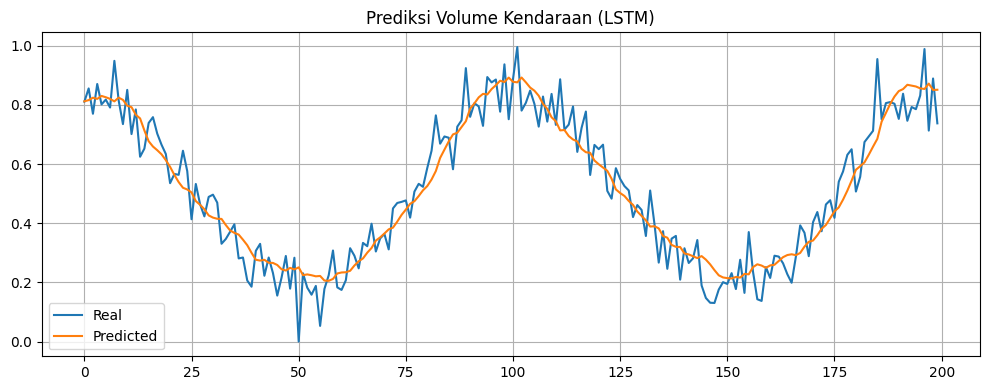

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 1. Generate Synthetic Data
np.random.seed(42)
n_samples = 1000
time = pd.date_range("2023-01-01", periods=n_samples, freq="H")

volume = np.sin(np.linspace(0, 20 * np.pi, n_samples)) * 100 + 300 + np.random.normal(0, 20, n_samples)
cuaca = np.random.choice(['cerah', 'hujan', 'berawan'], n_samples)
macet = (volume > 380).astype(int)

df = pd.DataFrame({
    'waktu': time,
    'volume_kendaraan': volume,
    'cuaca': cuaca,
    'jam': time.hour,
    'hari': time.dayofweek,
    'macet': macet
})

# 2. Preprocessing
label_encoder = LabelEncoder()
df['cuaca_encoded'] = label_encoder.fit_transform(df['cuaca'])

scaler = MinMaxScaler()
df['volume_scaled'] = scaler.fit_transform(df[['volume_kendaraan']])

X_rf = df[['volume_kendaraan', 'cuaca_encoded', 'jam', 'hari']]
y_rf = df['macet']
lstm_data = df[['volume_scaled']].values

# 3. Random Forest (Classification)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)

print("=== Random Forest Evaluation ===")
print(confusion_matrix(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("F1 Score:", f1_score(y_test_rf, y_pred_rf))

# 4. LSTM (Time Series Prediction)
seq_length = 24
generator = TimeseriesGenerator(lstm_data, lstm_data, length=seq_length, batch_size=32)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=10, verbose=1)

predicted = model.predict(generator)
real = lstm_data[seq_length:]

mae = mean_absolute_error(real, predicted)

print("\n=== LSTM Evaluation ===")
print("MAE:", mae)

# 5. Plot LSTM Predictions
plt.figure(figsize=(10, 4))
plt.plot(real[:200], label='Real')
plt.plot(predicted[:200], label='Predicted')
plt.title("Prediksi Volume Kendaraan (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
